# Cibolo Basin: SPI and SPEI Calculations

This workbook calculates the 3-, 4-, 6-, and 12-month Standardized Precipitation Index (SPI) and Standardized Precipitation Evapotranspiration Index (SPEI) for the Cibolo basin.

These two 'standardized' indices are calculated by:

1. Fitting a probability distribution to the data set
2. Determining a probability value for each value in the data set
3. Transforming this probability to an equivalent ZScore from the standard normal distribution.
    * The ZScore value provides the index value

The SPI is calculated from monthly total precipitation. The monthly totals are aggregated to 3-, 6-, and 12-month rolling windows to create the data set value generates the SPI.
* Pearson Type III (or 3 parameter Gamma) distribution is used for SPI

The SPEI uses the total monthly deficit and aggregated monthly deficits using 3-, 6-, and 12-month rolling windows to create the data set values for the SPEI.
* Log-logistic distribution (3 parameter) is used for SPEI

The deficit ($D$) is:

\begin{equation*}
    D_{i} = P_{i} - PET_{i}
\end{equation*}

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as sstats
from math import exp
import datetime as dt
import seaborn as sns
import pickle

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
IN_DIR = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\Processed_Historical'
OUT_DIR = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\Processed_Historical\SPEI'

In [5]:
StartTS = pd.Timestamp( 1980, 1, 1, 0, )
StopTS = pd.Timestamp( 2010, 12, 31, 23, )

In [6]:
# our standard normal or ZScore parameters
ZMu = 0.0
ZStd = 1.0

In [7]:
BasKey = "Cibolo"

Lambdas

In [8]:
# lambdas
ConvCFStoM3D = lambda cfs: ( cfs * ( ( 24.0 * 60.0 * 60.0 ) / 1.0 ) ) * ( pow(1.0, 3.0) / pow( 3.280839895, 3.0 ) )

## Load the Data

Need to load the values from multiple spreadsheets, 1 per HRU. Want to collect the individual HRU DataFrames to a single DataFrame containing values for all HRUs

In [9]:
InFiler = os.path.normpath( os.path.join( IN_DIR, "FBas_MetTS_1980through2020_Dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    BasinsDFDict = pickle.load( IF )
# end with
medDF = BasinsDFDict[BasKey]

In [10]:
display( HTML( medDF.head().to_html() ) )

,Pre_mm,MaxT_C,MinT_C,AveT_C,ETo_mm,Def_mm
1980-01-01,0.0,17.824719,-2.297086,7.763817,1.732393,-1.732393
1980-01-02,0.0,19.698328,-0.205801,9.746264,1.871460,-1.871460
1980-01-03,0.0,12.644474,5.003540,8.824007,1.813793,-1.813793
1980-01-04,0.0,15.457218,-3.787890,5.834664,1.614595,-1.614595
1980-01-05,0.0,17.664454,-2.898446,7.383004,1.725581,-1.725581


In [11]:
display( HTML( medDF.tail().to_html() ) )

,Pre_mm,MaxT_C,MinT_C,AveT_C,ETo_mm,Def_mm
2020-12-27,0.084964,23.740073,3.559144,13.649609,2.400960,-2.315996
2020-12-28,1.357298,23.879383,8.854662,16.367022,2.612492,-1.255193
2020-12-29,0.738643,22.499156,15.311331,18.905243,2.811725,-2.073082
2020-12-30,11.345187,19.731934,11.002448,15.367191,2.545966,8.799221
2020-12-31,11.345187,19.731934,11.002448,15.367191,2.545966,8.799221


In [12]:
InFiler = os.path.normpath( os.path.join( IN_DIR, "FBas_MetTS_2021through2022_Dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    BasinsDFDict = pickle.load( IF )
# end with
newMedDF = BasinsDFDict[BasKey]

In [13]:
fullMedDF = pd.concat( [ medDF, newMedDF ], )

In [14]:
display( HTML( fullMedDF.head().to_html() ) )

,Pre_mm,MaxT_C,MinT_C,AveT_C,ETo_mm,Def_mm
1980-01-01,0.0,17.824719,-2.297086,7.763817,1.732393,-1.732393
1980-01-02,0.0,19.698328,-0.205801,9.746264,1.871460,-1.871460
1980-01-03,0.0,12.644474,5.003540,8.824007,1.813793,-1.813793
1980-01-04,0.0,15.457218,-3.787890,5.834664,1.614595,-1.614595
1980-01-05,0.0,17.664454,-2.898446,7.383004,1.725581,-1.725581


In [15]:
display( HTML( fullMedDF.tail().to_html() ) )

,Pre_mm,MaxT_C,MinT_C,AveT_C,ETo_mm,Def_mm
2022-12-27,0.000000,17.296607,-3.626105,6.835251,1.627117,-1.627117
2022-12-28,0.000000,22.615419,0.118791,11.367105,1.928930,-1.928930
2022-12-29,0.000000,20.907962,6.950069,13.929016,2.101448,-2.101448
2022-12-30,1.073958,18.602779,5.365450,11.984115,1.976422,-0.902464
2022-12-31,1.073958,18.602779,5.365450,11.984115,1.980387,-0.906428


In [16]:
medDF = medDF.loc[StartTS:StopTS].copy()

In [17]:
baPre = medDF["Pre_mm"].to_numpy(dtype=np.float32)
baDef = medDF["Def_mm"].to_numpy(dtype=np.float32)

## Aggregate to Desired Durations or Windows

Use 3-, 6-, and 12-month durations. These are moving average windows so first make monthly precipitation and deficit total time series.

In [18]:
MonDF = medDF.resample( 'MS', ).sum()
ExtMonDF = fullMedDF.resample( 'MS', ).sum()

In [19]:
PreMonDF = MonDF[["Pre_mm"]].copy()
ExtPreMonDF = ExtMonDF[["Pre_mm"]].copy()

### Precipitation

In [20]:
P3DF = PreMonDF.rolling(window=3,).sum()
P4DF = PreMonDF.rolling(window=4,).sum()
P6DF = PreMonDF.rolling(window=6,).sum()
P12DF = PreMonDF.rolling(window=12,).sum()

In [21]:
extP3DF = ExtPreMonDF.rolling(window=3,).sum()
extP4DF = ExtPreMonDF.rolling(window=4,).sum()
extP6DF = ExtPreMonDF.rolling(window=6,).sum()
extP12DF = ExtPreMonDF.rolling(window=12,).sum()

Now chop off the first year to get rid of the 'NaN' values. Assume that meteorology data sets always start on the first day of the calendar year.

In [22]:
OrgStartTS = PreMonDF.index[0]
NewStartTS = pd.Timestamp( OrgStartTS.year + 1, 1, 1 )
NewStartTS

Timestamp('1981-01-01 00:00:00')

In [23]:
PreMonDF = PreMonDF.loc[NewStartTS:].copy()
P3DF = P3DF.loc[NewStartTS:].copy()
P4DF = P4DF.loc[NewStartTS:].copy()
P6DF = P6DF.loc[NewStartTS:].copy()
P12DF = P12DF.loc[NewStartTS:].copy()

In [24]:
ExtPreMonDF = ExtPreMonDF.loc[NewStartTS:].copy()
extP3DF = extP3DF.loc[NewStartTS:].copy()
extP4DF = extP4DF.loc[NewStartTS:].copy()
extP6DF = extP6DF.loc[NewStartTS:].copy()
extP12DF = extP12DF.loc[NewStartTS:].copy()

Add an integer month column to facilitate processing

In [25]:
PreMonDF["Month"] = PreMonDF.index.month
P3DF["Month"] = P3DF.index.month
P4DF["Month"] = P4DF.index.month
P6DF["Month"] = P6DF.index.month
P12DF["Month"] = P12DF.index.month

In [26]:
ExtPreMonDF["Month"] = ExtPreMonDF.index.month
extP3DF["Month"] = extP3DF.index.month
extP4DF["Month"] = extP4DF.index.month
extP6DF["Month"] = extP6DF.index.month
extP12DF["Month"] = extP12DF.index.month

### Deficit

In [27]:
DefMonDF = MonDF[["Def_mm"]].copy()
ExtDefMonDF = ExtMonDF[["Def_mm"]].copy()

In [28]:
D3DF = DefMonDF.rolling(window=3,).sum()
D4DF = DefMonDF.rolling(window=4,).sum()
D6DF = DefMonDF.rolling(window=6,).sum()
D12DF = DefMonDF.rolling(window=12,).sum()

In [29]:
extD3DF = ExtDefMonDF.rolling(window=3,).sum()
extD4DF = ExtDefMonDF.rolling(window=4,).sum()
extD6DF = ExtDefMonDF.rolling(window=6,).sum()
extD12DF = ExtDefMonDF.rolling(window=12,).sum()

In [30]:
DefMonDF = DefMonDF.loc[NewStartTS:].copy()
D3DF = D3DF.loc[NewStartTS:].copy()
D4DF = D4DF.loc[NewStartTS:].copy()
D6DF = D6DF.loc[NewStartTS:].copy()
D12DF = D12DF.loc[NewStartTS:].copy()

In [31]:
ExtDefMonDF = ExtDefMonDF.loc[NewStartTS:].copy()
extD3DF = extD3DF.loc[NewStartTS:].copy()
extD4DF = extD4DF.loc[NewStartTS:].copy()
extD6DF = extD6DF.loc[NewStartTS:].copy()
extD12DF = extD12DF.loc[NewStartTS:].copy()

In [32]:
DefMonDF["Month"] = DefMonDF.index.month
D3DF["Month"] = D3DF.index.month
D4DF["Month"] = D4DF.index.month
D6DF["Month"] = D6DF.index.month
D12DF["Month"] = D12DF.index.month

In [33]:
ExtDefMonDF["Month"] = ExtDefMonDF.index.month
extD3DF["Month"] = extD3DF.index.month
extD4DF["Month"] = extD4DF.index.month
extD6DF["Month"] = extD6DF.index.month
extD12DF["Month"] = extD12DF.index.month

## Fit Distributions and Calculate Indices

### SPI: Pearson Type III

Fit Pearson Type III Distributions to each month and each window length.

Scipy stats fit for Pearson Type III returns a tuple with:

0. **skew**
1. **location**
2. **scale**

The cumulative distribution function (for Pearson Type III) is then used to estimate a cumulative probability for each moving sum value (i.e., each calendar month across all years in the data set). The cumulative probability is then transformed into a Z-Score using the standard normal distribution.

In [34]:
procCols = list( PreMonDF.columns )

In [35]:
procCols.remove( "Month" )

In [36]:
procCols

['Pre_mm']

In [37]:
TotYears = ( 2010 - 1981 ) + 1
TotYears

30

In [38]:
TotEstYears = (2022 - 1981) + 1
TotEstYears

42

In [39]:
# outer loop by DataFrame columns
hCnt = 0
for tHdr in procCols:
    print("Working on %s" % tHdr)
    # get the full arrays
    extCols = [ tHdr, "Month"]
    c3DF = P3DF[extCols].copy()
    c4DF = P4DF[extCols].copy()
    c6DF = P6DF[extCols].copy()
    c12DF = P12DF[extCols].copy()
    extC3DF = extP3DF[extCols].copy()
    extC4DF = extP4DF[extCols].copy()
    extC6DF = extP6DF[extCols].copy()
    extC12DF = extP12DF[extCols].copy()
    # create empty tracking dictionaries
    M3MonDict = dict()
    M4MonDict = dict()
    M6MonDict = dict()
    M12MonDict = dict()
    # loop through by integer month
    for mI in range(1, 13, 1):
        # get our basic arrays of values - these are calendar ordered
        m3Mon = c3DF[c3DF["Month"] == mI].copy()
        a3Mon = m3Mon[tHdr].to_numpy()
        extM3Mon = extC3DF[extC3DF["Month"] == mI].copy()
        extA3Mon = extM3Mon[tHdr].to_numpy()
        m4Mon = c4DF[c4DF["Month"] == mI].copy()
        a4Mon = m4Mon[tHdr].to_numpy()
        extM4Mon = extC4DF[extC4DF["Month"] == mI].copy()
        extA4Mon = extM4Mon[tHdr].to_numpy()
        m6Mon = c6DF[c6DF["Month"] == mI].copy()
        a6Mon = m6Mon[tHdr].to_numpy()
        extM6Mon = extC6DF[extC6DF["Month"] == mI].copy()
        extA6Mon = extM6Mon[tHdr].to_numpy()
        m12Mon = c12DF[c12DF["Month"] == mI].copy()
        a12Mon = m12Mon[tHdr].to_numpy()
        extM12Mon = extC12DF[extC12DF["Month"] == mI].copy()
        extA12Mon = extM12Mon[tHdr].to_numpy()
        # fit Pearson Type III distributions to these arrays
        fitT3Mon = sstats.pearson3.fit( a3Mon )
        lD3Mon = { "skew" : fitT3Mon[0], "location" : fitT3Mon[1],
                   "scale" : fitT3Mon[2], }
        fitT4Mon = sstats.pearson3.fit( a4Mon )
        lD4Mon = { "skew" : fitT4Mon[0], "location" : fitT4Mon[1],
                   "scale" : fitT4Mon[2], }
        fitT6Mon = sstats.pearson3.fit( a6Mon )
        lD6Mon = { "skew" : fitT6Mon[0], "location" : fitT6Mon[1],
                   "scale" : fitT6Mon[2], }
        fitT12Mon = sstats.pearson3.fit( a12Mon )
        lD12Mon = { "skew" : fitT12Mon[0], "location" : fitT12Mon[1],
                   "scale" : fitT12Mon[2], }
        # now get the cumulative probability values from the distributions
        #   for the observed values.
        data3MCDF = sstats.pearson3.cdf( extA3Mon, lD3Mon["skew"], loc=lD3Mon["location"], 
                                         scale=lD3Mon["scale"] )
        data4MCDF = sstats.pearson3.cdf( extA4Mon, lD4Mon["skew"], loc=lD4Mon["location"], 
                                         scale=lD4Mon["scale"] )
        data6MCDF = sstats.pearson3.cdf( extA6Mon, lD6Mon["skew"], loc=lD6Mon["location"], 
                                         scale=lD6Mon["scale"] )
        data12MCDF = sstats.pearson3.cdf( extA12Mon, lD12Mon["skew"], loc=lD12Mon["location"], 
                                          scale=lD12Mon["scale"] )
        # make sure the cumulative density is not less than 1.0 / (2* N years).
        data3MCDF = np.where( data3MCDF < (1.0/60.0), (1.0/60.0), data3MCDF )
        data4MCDF = np.where( data4MCDF < (1.0/60.0), (1.0/60.0), data4MCDF )
        data6MCDF = np.where( data6MCDF < (1.0/60.0), (1.0/60.0), data6MCDF )
        data12MCDF = np.where( data12MCDF < (1.0/60.0), (1.0/60.0), data12MCDF )
        SPI3Mo = sstats.norm.ppf( data3MCDF, loc=ZMu, scale=ZStd )
        SPI4Mo = sstats.norm.ppf( data4MCDF, loc=ZMu, scale=ZStd )
        SPI6Mo = sstats.norm.ppf( data6MCDF, loc=ZMu, scale=ZStd )
        SPI12Mo = sstats.norm.ppf( data12MCDF, loc=ZMu, scale=ZStd )
        # dictionary entries for this month
        M3MonDict[mI] = [ [data3MCDF, SPI3Mo, extA3Mon], lD3Mon ]
        M4MonDict[mI] = [ [data4MCDF, SPI4Mo, extA4Mon], lD4Mon ]
        M6MonDict[mI] = [ [data6MCDF, SPI6Mo, extA6Mon], lD6Mon ]
        M12MonDict[mI] = [ [data12MCDF, SPI12Mo, extA12Mon], lD12Mon ]
    # end for
    # rebuild time series representation from calendar month lists
    spi3mList = list()
    spi4mList = list()
    spi6mList = list()
    spi12mList = list()
    cprob3mList = list()
    cprob4mList = list()
    cprob6mList = list()
    cprob12mList = list()
    cumD3mList = list()
    cumD4mList = list()
    cumD6mList = list()
    cumD12mList = list()
    # loop through years and fill by month order
    for yI in range(TotEstYears):
        for mI in range(1, 13, 1):
            m3ArraySP = M3MonDict[mI][0][1]
            m4ArraySP = M4MonDict[mI][0][1]
            m6ArraySP = M6MonDict[mI][0][1]
            m12ArraySP = M12MonDict[mI][0][1]
            m3ArrayCP = M3MonDict[mI][0][0]
            m4ArrayCP = M4MonDict[mI][0][0]
            m6ArrayCP = M6MonDict[mI][0][0]
            m12ArrayCP = M12MonDict[mI][0][0]
            m3ArrayCD = M3MonDict[mI][0][2]
            m4ArrayCD = M4MonDict[mI][0][2]
            m6ArrayCD = M6MonDict[mI][0][2]
            m12ArrayCD = M12MonDict[mI][0][2]
            if yI < len( m3ArrayCP ):
                spi3mList.append( m3ArraySP[yI] )
                cprob3mList.append( m3ArrayCP[yI] )
                cumD3mList.append( m3ArrayCD[yI] )
            if yI < len( m4ArrayCP ):
                spi4mList.append( m4ArraySP[yI] )
                cprob4mList.append( m4ArrayCP[yI] )
                cumD4mList.append( m4ArrayCD[yI] )
            if yI < len( m6ArrayCP ):
                spi6mList.append( m6ArraySP[yI] )
                cprob6mList.append( m3ArrayCP[yI] )
                cumD6mList.append( m6ArrayCD[yI] )
            if yI < len( m12ArrayCP ):
                spi12mList.append( m12ArraySP[yI] )
                cprob12mList.append( m3ArrayCP[yI] )
                cumD12mList.append( m12ArrayCD[yI] )
        # end inner for
    # end outer for
    # now build the time indexed DataFrame
    DataDict = { "CumPre" : np.array( cumD3mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob3mList, dtype=np.float32 ), 
                 "SPI" : np.array( spi3mList, dtype=np.float32 ), }
    cSPI_3 = pd.DataFrame( index=extC3DF.index, data=DataDict )
    cSPI_3["5xCumProb"] = 5.0*cSPI_3["CumProb"]
    DataDict = { "CumPre" : np.array( cumD4mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob4mList, dtype=np.float32 ), 
                 "SPI" : np.array( spi4mList, dtype=np.float32 ), }
    cSPI_4 = pd.DataFrame( index=extC4DF.index, data=DataDict )
    cSPI_4["5xCumProb"] = 5.0*cSPI_4["CumProb"]
    DataDict = { "CumPre" : np.array( cumD6mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob6mList, dtype=np.float32 ), 
                 "SPI" : np.array( spi6mList, dtype=np.float32 ), }
    cSPI_6 = pd.DataFrame( index=extC6DF.index, data=DataDict )
    cSPI_6["5xCumProb"] = 5.0*cSPI_6["CumProb"]
    DataDict = { "CumPre" : np.array( cumD12mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob12mList, dtype=np.float32 ), 
                 "SPI" : np.array( spi12mList, dtype=np.float32 ),  }
    cSPI_12 = pd.DataFrame( index=extC12DF.index, data=DataDict )
    cSPI_12["5xCumProb"] = 5.0*cSPI_12["CumProb"]
    if hCnt == 0:
        spi3DF = cSPI_3.copy()
        spi4DF = cSPI_4.copy()
        spi6DF = cSPI_6.copy()
        spi12DF = cSPI_12.copy()
    else:
        spi3DF = spi3DF.merge( cSPI_3, how='inner', left_index=True, right_index=True )
        spi4DF = spi4DF.merge( cSPI_4, how='inner', left_index=True, right_index=True )
        spi6DF = spi6DF.merge( cSPI_6, how='inner', left_index=True, right_index=True )
        spi12DF = spi12DF.merge( cSPI_12, how='inner', left_index=True, right_index=True )
    # end if
    # now do the stats
    stats3List = list()
    stats4List = list()
    stats6List = list()
    stats12List = list()
    indNList = list()
    for mI in range(1, 13, 1):
        lD3Mon = M3MonDict[mI][1]
        lD4Mon = M4MonDict[mI][1]
        lD6Mon = M6MonDict[mI][1]
        lD12Mon = M12MonDict[mI][1]
        indNList.append( "skew_%d" % mI )
        indNList.append( "scale_%d" % mI )
        indNList.append( "loc_%d" % mI )
        stats3List.append( lD3Mon["skew"] )
        stats3List.append( lD3Mon["scale"] )
        stats3List.append( lD3Mon["location"] )
        stats4List.append( lD4Mon["skew"] )
        stats4List.append( lD4Mon["scale"] )
        stats4List.append( lD4Mon["location"] )
        stats6List.append( lD6Mon["skew"] )
        stats6List.append( lD6Mon["scale"] )
        stats6List.append( lD6Mon["location"] )
        stats12List.append( lD12Mon["skew"] )
        stats12List.append( lD12Mon["scale"] )
        stats12List.append( lD12Mon["location"] )
    # end for
    # build our DataFrames
    c3StatsDF = pd.DataFrame( index=indNList, data={"SPI Fit Stats" : stats3List,} )
    c4StatsDF = pd.DataFrame( index=indNList, data={"SPI Fit Stats" : stats4List,} )
    c6StatsDF = pd.DataFrame( index=indNList, data={"SPI Fit Stats" : stats6List,} )
    c12StatsDF = pd.DataFrame( index=indNList, data={"SPI Fit Stats" : stats12List,} )
    if hCnt == 0:
        stats3DF = c3StatsDF.copy()
        stats4DF = c4StatsDF.copy()
        stats6DF = c6StatsDF.copy()
        stats12DF = c12StatsDF.copy()
    else:
        stats3DF = stats3DF.merge( c3StatsDF, how='inner', left_index=True, right_index=True )
        stats4DF = stats4DF.merge( c4StatsDF, how='inner', left_index=True, right_index=True )
        stats6DF = stats6DF.merge( c6StatsDF, how='inner', left_index=True, right_index=True )
        stats12DF = stats12DF.merge( c12StatsDF, how='inner', left_index=True, right_index=True )
    # end if
    # increment the hCnt
    hCnt += 1
# end header for

Working on Pre_mm


#### Output

In [40]:
display( HTML( spi4DF.head().to_html() ) )

,CumPre,CumProb,SPI,5xCumProb
1981-01-01,222.931702,0.397278,-0.260400,1.986387
1981-02-01,227.212524,0.555588,0.139792,2.777939
1981-03-01,205.077499,0.510507,0.026339,2.552533
1981-04-01,246.403351,0.629309,0.330025,3.146546
1981-05-01,328.994690,0.670300,0.440743,3.351501


In [41]:
display( HTML( stats12DF.head().to_html() ) )

,SPI Fit Stats
skew_1,-0.210774
scale_1,269.937572
loc_1,907.990017
skew_2,0.464002
scale_2,271.198915


Output to a spreadsheet

In [42]:
outXLSX = os.path.normpath( os.path.join( OUT_DIR, BasKey, "%s_SPI.xlsx" % BasKey ) )
writer = pd.ExcelWriter( outXLSX )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00000'})
cLabel = "Monthly_CN"
PreMonDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in PreMonDF:
    column_width = max(PreMonDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = PreMonDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Monthly_Ext"
ExtPreMonDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ExtPreMonDF:
    column_width = max(ExtPreMonDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = ExtPreMonDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_3mo"
stats3DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats3DF:
    column_width = max(stats3DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats3DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_4mo"
stats4DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats4DF:
    column_width = max(stats4DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats4DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_6mo"
stats6DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats6DF:
    column_width = max(stats6DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats6DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_12mo"
stats12DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats12DF:
    column_width = max(stats12DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats12DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPI_3mo"
spi3DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spi3DF:
    column_width = max(spi3DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spi3DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPI_4mo"
spi4DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spi4DF:
    column_width = max(spi4DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spi4DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPI_6mo"
spi6DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spi6DF:
    column_width = max(spi6DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spi6DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPI_12mo"
spi12DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spi12DF:
    column_width = max(spi12DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spi12DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()

### SPEI: Log-Logistic

[Vicente-Serrano and others (2010)](https://journals.ametsoc.org/view/journals/clim/23/7/2009jcli2909.1.xml) developed the Standardized Precipitation Evapotranspiration Index (SPEI) to provide a climatic drought index that would be sensitive to global warming. The SPEI is congruent with the SPI; the primary difference is that monthly deficit (D) values are used in place of monthly precipitation (P) values. They also found that the log-logistic distribution (3 parameter) performed better than the Pearson Type III (or 3 parameter Gamma) distribution for calculating the SPEI from D values, which tend to be mostly negative in arid and semi-arid environments.

Unfortunately, the log-logistic distribution is not currently included in [SciPy stats](https://docs.scipy.org/doc/scipy/tutorial/stats.html) which is the package used for other distributions in this notebook (i.e., [Pearson Type III](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearson3.html) and [Normal](https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_norm.html) ).

In searching for a log-logistic implementation to use for the SPEI calculation, [Hosking and Wallis (1997) Regional Frequency Analysis](https://www.cambridge.org/core/books/regional-frequency-analysis/8C59835F9361705DAAE1ADFDEA7ECD30) provides a 'Generalized Logistic Distribution' in the Appendix with the information needed to estimate probability distribution values. The 'Generalized Logistic Distribution' is a reparameterized version of the log-logistic distribution of [Ahmad and others (1988)](https://www.sciencedirect.com/science/article/abs/pii/0022169488900157).

Two custom functions are presented below to calculate the probability distribution values using the 'Generalized Logistic Distribution' which provides a log-logistic distribution when the shape parameter (or $k$) is not equal to zero. After developing and testing these functions against the [lmoment3 package](https://open-hydrology.readthedocs.io/projects/lmoments3/en/stable/), the [Generalized Logistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genlogistic.html#scipy.stats.genlogistic) implementation in Scipy stats was discovered.

The custom function, L-moments approach is used going forward to calculate SPEI because:

1. lmoment3 package is not up to date with current versions of SciPy and will throw errors
2. SciPy Stats Genlogistic does not work with negative shape parameters and so cannot use the L-moment estimated distribution parameters. MLE-based parameter estimates seem close and reasonable but it is thought that the custom L-moments approach will be more stable in general.

In [43]:
def estimatellogparams( npArray ):
    """Estimate the parameters of a log-logistic distribution from an
    array of annual values.
    
    Estimate is done using L-moments and the "Generalized logistic distribution".
    This distribtion is a reparameterized version of the log-logistic
    distribution of Ahmad et al. (1988). Estimation is done using 
    the equations and procedure in Appendix A.7 of "Regional Frequency
    Analysis", Hosking and Wallis (1997)
    
    To estimate the distribution parameters (shape, scale, and location),
    the L-moments l1, l2, and t3 need to be calculated. These three
    L-moments can be estimated from the first three, sample weighted
    probability moments (b0, b1, and b2).
    
    Args:
        npArray (np.ndarray): Numpy, 1D array
    
    Returns:
        log-logistic parameters in dictionary, D:
            D["k"]: k or shape
            D["scale"]: alpha or scale
            D["loc"]: Eta or location
    """
    # imports
    import math
    # don't do any checking for type and assume that will always
    #  be Numpy ndarray for single argument
    totLen = len( npArray )
    # need a sorted array in increasing order
    srtAr = np.sort( npArray )
    # calculate sample probability weighted moments: b0, b1, b2
    b0 = srtAr.mean()
    b1 = 0.0
    for iI in range(2, totLen + 1):
        b1 += ( ( iI - 1 ) / ( totLen - 1 ) ) * srtAr[iI-1]
    # end for
    b1 = b1 / totLen
    b2 = 0.0
    for iI in range( 3, totLen + 1 ):
        b2 += ( ( ( iI - 1 ) * ( iI - 2 ) ) / ( ( totLen - 1 ) * (totLen - 2 ) ) ) * srtAr[iI-1]
    # end for
    b2 = b2 / totLen
    # calculate sample L-moments: l1, l2, t3
    l1 = b0
    l2 = (2.0 * b1 ) - b0
    l3 = ( 6.0 * b2 ) -  ( 6.0 * b1 ) + b0
    t3 = l3 / l2
    # estimate the distribution parameters
    shape = -1.0 * t3
    scale = ( l2 * math.sin( shape * math.pi ) ) / ( shape * math.pi )
    location = l1 - ( scale * ( ( 1.0 / shape ) - ( math.pi / math.sin( shape * math.pi ) ) ) )
    retDict = { "k" : shape,
                "scale" : scale,
                "loc" : location, }
    # return
    return retDict

In [44]:
def probDistLLogis( paramDict, npArray ):
    """Uses generalized logistic probability distribution to estimate cumulative
    probilities for each value in the Numpy array, npArray.
    
    Args:
        paramDict (dict): dictionary with best-fit parameter values for a 
                log-logisitic distribution. Must have keys: "k", "scale",
                "loc" which are the 3 required parameters
        npArray (np.ndarray): array from time series of monthly, rolling
                average values
    
    Returns:
        retArray (np.ndarray): cumulative probabilies for each npArray value
    """
    shape = paramDict["k"]
    location = paramDict["loc"]
    scale = paramDict["scale"]
    if shape == 0.0:
        # this is the special case of a logistic distribution with 2 params
        y = ( npArray - location ) / scale
    else:
        # this is the general case of the log-logistic distribution
        takeLogArray = 1.0 - ( shape * ( npArray - location ) / scale )
        useLogArray = np.where( takeLogArray <= 0.0, 1e-7, takeLogArray )
        y = ( -1.0 * ( 1.0 / shape ) ) * np.log( useLogArray )
    # end if
    retArray = 1.0 / ( 1.0 + np.exp( -1.0 * y  ) )
    # return
    return retArray

In [45]:
procCols = list( DefMonDF.columns )

In [46]:
procCols.remove( "Month" )

In [47]:
procCols

['Def_mm']

In [48]:
# outer loop by DataFrame columns
hCnt = 0
for tHdr in procCols:
    print("Working on %s" % tHdr)
    # get the full arrays
    extCols = [ tHdr, "Month"]
    c3DF = D3DF[extCols].copy()
    c4DF = D4DF[extCols].copy()
    c6DF = D6DF[extCols].copy()
    c12DF = D12DF[extCols].copy()
    extC3DF = extD3DF[extCols].copy()
    extC4DF = extD4DF[extCols].copy()
    extC6DF = extD6DF[extCols].copy()
    extC12DF = extD12DF[extCols].copy()
    # create empty tracking dictionaries
    M3MonDict = dict()
    M4MonDict = dict()
    M6MonDict = dict()
    M12MonDict = dict()
    # loop through by integer month
    for mI in range(1, 13, 1):
        # get our basic arrays of values - these are calendar ordered
        m3Mon = c3DF[c3DF["Month"] == mI].copy()
        a3Mon = m3Mon[tHdr].to_numpy()
        extM3Mon = extC3DF[extC3DF["Month"] == mI].copy()
        extA3Mon = extM3Mon[tHdr].to_numpy()
        m4Mon = c4DF[c4DF["Month"] == mI].copy()
        a4Mon = m4Mon[tHdr].to_numpy()
        extM4Mon = extC4DF[extC4DF["Month"] == mI].copy()
        extA4Mon = extM4Mon[tHdr].to_numpy()
        m6Mon = c6DF[c6DF["Month"] == mI].copy()
        a6Mon = m6Mon[tHdr].to_numpy()
        extM6Mon = extC6DF[extC6DF["Month"] == mI].copy()
        extA6Mon = extM6Mon[tHdr].to_numpy()
        m12Mon = c12DF[c12DF["Month"] == mI].copy()
        a12Mon = m12Mon[tHdr].to_numpy()
        extM12Mon = extC12DF[extC12DF["Month"] == mI].copy()
        extA12Mon = extM12Mon[tHdr].to_numpy()
        # fit 'generalized logistic' distributions to these arrays
        lD3Mon = estimatellogparams( a3Mon )
        lD4Mon = estimatellogparams( a4Mon )
        lD6Mon = estimatellogparams( a6Mon )
        lD12Mon = estimatellogparams( a12Mon )
        # now get the cumulative probability values from the distributions
        #   for the observed values.
        data3MCDF = probDistLLogis( lD3Mon, extA3Mon )
        data4MCDF = probDistLLogis( lD4Mon, extA4Mon )
        data6MCDF = probDistLLogis( lD6Mon, extA6Mon )
        data12MCDF = probDistLLogis( lD12Mon, extA12Mon )
        # make sure the cumulative density is not less than 1.0 / (2* N years).
        data3MCDF = np.where( data3MCDF < (1.0/60.0), (1.0/60.0), data3MCDF )
        data4MCDF = np.where( data4MCDF < (1.0/60.0), (1.0/60.0), data4MCDF )
        data6MCDF = np.where( data6MCDF < (1.0/60.0), (1.0/60.0), data6MCDF )
        data12MCDF = np.where( data12MCDF < (1.0/60.0), (1.0/60.0), data12MCDF )
        SPEI3Mo = sstats.norm.ppf( data3MCDF, loc=ZMu, scale=ZStd )
        SPEI4Mo = sstats.norm.ppf( data4MCDF, loc=ZMu, scale=ZStd )
        SPEI6Mo = sstats.norm.ppf( data6MCDF, loc=ZMu, scale=ZStd )
        SPEI12Mo = sstats.norm.ppf( data12MCDF, loc=ZMu, scale=ZStd )
        # dictionary entries for this month
        M3MonDict[mI] = [ [data3MCDF, SPEI3Mo, extA3Mon], lD3Mon ]
        M4MonDict[mI] = [ [data4MCDF, SPEI4Mo, extA4Mon], lD4Mon ]
        M6MonDict[mI] = [ [data6MCDF, SPEI6Mo, extA6Mon], lD6Mon ]
        M12MonDict[mI] = [ [data12MCDF, SPEI12Mo, extA12Mon], lD12Mon ]
    # end for
    # rebuild time series representation from calendar month lists
    spei3mList = list()
    spei4mList = list()
    spei6mList = list()
    spei12mList = list()
    cprob3mList = list()
    cprob4mList = list()
    cprob6mList = list()
    cprob12mList = list()
    cumD3mList = list()
    cumD4mList = list()
    cumD6mList = list()
    cumD12mList = list()
    # loop through years and fill by month order
    for yI in range(TotEstYears):
        for mI in range(1, 13, 1):
            m3ArraySP = M3MonDict[mI][0][1]
            m4ArraySP = M4MonDict[mI][0][1]
            m6ArraySP = M6MonDict[mI][0][1]
            m12ArraySP = M12MonDict[mI][0][1]
            m3ArrayCP = M3MonDict[mI][0][0]
            m4ArrayCP = M4MonDict[mI][0][0]
            m6ArrayCP = M6MonDict[mI][0][0]
            m12ArrayCP = M12MonDict[mI][0][0]
            m3ArrayCD = M3MonDict[mI][0][2]
            m4ArrayCD = M4MonDict[mI][0][2]
            m6ArrayCD = M6MonDict[mI][0][2]
            m12ArrayCD = M12MonDict[mI][0][2]
            if yI < len( m3ArrayCP ):
                spei3mList.append( m3ArraySP[yI] )
                cprob3mList.append( m3ArrayCP[yI] )
                cumD3mList.append( m3ArrayCD[yI] )
            if yI < len( m4ArrayCP ):
                spei4mList.append( m4ArraySP[yI] )
                cprob4mList.append( m4ArrayCP[yI] )
                cumD4mList.append( m4ArrayCD[yI] )
            if yI < len( m6ArrayCP ):
                spei6mList.append( m6ArraySP[yI] )
                cprob6mList.append( m6ArrayCP[yI] )
                cumD6mList.append( m6ArrayCD[yI] )
            if yI < len( m12ArrayCP ):
                spei12mList.append( m12ArraySP[yI] )
                cprob12mList.append( m12ArrayCP[yI] )
                cumD12mList.append( m12ArrayCD[yI] )
        # end inner for
    # end outer for
    # now build the time indexed DataFrame
    DataDict = { "CumDef" : np.array( cumD3mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob3mList, dtype=np.float32 ), 
                 "SPEI" : np.array( spei3mList, dtype=np.float32 ),  }
    cSPEI_3 = pd.DataFrame( index=extC3DF.index, data=DataDict )
    cSPEI_3["5xCumProb"] = 5.0*cSPEI_3["CumProb"]
    DataDict = { "CumDef" : np.array( cumD4mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob4mList, dtype=np.float32 ), 
                 "SPEI" : np.array( spei4mList, dtype=np.float32 ),  }
    cSPEI_4 = pd.DataFrame( index=extC4DF.index, data=DataDict )
    cSPEI_4["5xCumProb"] = 5.0*cSPEI_4["CumProb"]
    DataDict = { "CumDef" : np.array( cumD6mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob3mList, dtype=np.float32 ), 
                 "SPEI" : np.array( spei3mList, dtype=np.float32 ),  }
    cSPEI_6 = pd.DataFrame( index=extC6DF.index, data=DataDict )
    cSPEI_6["5xCumProb"] = 5.0*cSPEI_6["CumProb"]
    DataDict = { "CumDef" : np.array( cumD12mList, dtype=np.float32 ),
                 "CumProb" : np.array( cprob3mList, dtype=np.float32 ), 
                 "SPEI" : np.array( spei3mList, dtype=np.float32 ),  }
    cSPEI_12 = pd.DataFrame( index=extC12DF.index, data=DataDict )
    cSPEI_12["5xCumProb"] = 5.0*cSPEI_12["CumProb"]
    if hCnt == 0:
        spei3DF = cSPEI_3.copy()
        spei4DF = cSPEI_4.copy()
        spei6DF = cSPEI_6.copy()
        spei12DF = cSPEI_12.copy()
    else:
        spei3DF = spei3DF.merge( cSPEI_3, how='inner', left_index=True, right_index=True )
        spei4DF = spei4DF.merge( cSPEI_4, how='inner', left_index=True, right_index=True )
        spei6DF = spei6DF.merge( cSPEI_6, how='inner', left_index=True, right_index=True )
        spei12DF = spei12DF.merge( cSPEI_12, how='inner', left_index=True, right_index=True )
    # end if
    # now do the stats
    stats3List = list()
    stats4List = list()
    stats6List = list()
    stats12List = list()
    indNList = list()
    for mI in range(1, 13, 1):
        lD3Mon = M3MonDict[mI][1]
        lD4Mon = M4MonDict[mI][1]
        lD6Mon = M6MonDict[mI][1]
        lD12Mon = M12MonDict[mI][1]
        indNList.append( "shape_%d" % mI )
        indNList.append( "scale_%d" % mI )
        indNList.append( "loc_%d" % mI )
        stats3List.append( lD3Mon["k"] )
        stats3List.append( lD3Mon["scale"] )
        stats3List.append( lD3Mon["loc"] )
        stats4List.append( lD4Mon["k"] )
        stats4List.append( lD4Mon["scale"] )
        stats4List.append( lD4Mon["loc"] )
        stats6List.append( lD6Mon["k"] )
        stats6List.append( lD6Mon["scale"] )
        stats6List.append( lD6Mon["loc"] )
        stats12List.append( lD12Mon["k"] )
        stats12List.append( lD12Mon["scale"] )
        stats12List.append( lD12Mon["loc"] )
    # end for
    # build our DataFrames
    c3StatsDF = pd.DataFrame( index=indNList, data={"SPEI Fit Stats": stats3List,} )
    c4StatsDF = pd.DataFrame( index=indNList, data={"SPEI Fit Stats": stats4List,} )
    c6StatsDF = pd.DataFrame( index=indNList, data={"SPEI Fit Stats": stats6List,} )
    c12StatsDF = pd.DataFrame( index=indNList, data={"SPEI Fit Stats": stats12List,} )
    if hCnt == 0:
        stats3DDF = c3StatsDF.copy()
        stats4DDF = c4StatsDF.copy()
        stats6DDF = c6StatsDF.copy()
        stats12DDF = c12StatsDF.copy()
    else:
        stats3DDF = stats3DDF.merge( c3StatsDF, how='inner', left_index=True, right_index=True )
        stats4DDF = stats4DDF.merge( c4StatsDF, how='inner', left_index=True, right_index=True )
        stats6DDF = stats6DDF.merge( c6StatsDF, how='inner', left_index=True, right_index=True )
        stats12DDF = stats12DDF.merge( c12StatsDF, how='inner', left_index=True, right_index=True )
    # end if
    # increment the hCnt
    hCnt += 1
# end header for

Working on Def_mm


In [49]:
display( HTML( spei4DF.head().to_html() ) )

,CumDef,CumProb,SPEI,5xCumProb
1981-01-01,-84.846100,0.351381,-0.381594,1.756906
1981-02-01,-38.933773,0.522057,0.055316,2.610284
1981-03-01,-95.989586,0.518169,0.045558,2.590845
1981-04-01,-131.865982,0.610844,0.281518,3.054218
1981-05-01,-152.492172,0.666919,0.431421,3.334594


In [50]:
display( HTML( stats12DDF.head().to_html() ) )

,SPEI Fit Stats
shape_1,-0.004343
scale_1,184.637323
loc_1,-601.657982
shape_2,-0.045807
scale_2,181.152092


Output to a spreadsheet for later analysis

In [51]:
outXLSX = os.path.normpath( os.path.join( OUT_DIR, BasKey, "%s_SPEI.xlsx" % BasKey ) )
writer = pd.ExcelWriter( outXLSX )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00000'})
cLabel = "Monthly_CN"
DefMonDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in DefMonDF:
    column_width = max(DefMonDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = DefMonDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Monthly_Ext"
ExtDefMonDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ExtDefMonDF:
    column_width = max(ExtDefMonDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = ExtDefMonDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_3mo"
stats3DDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats3DDF:
    column_width = max(stats3DDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats3DDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_4mo"
stats4DDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats4DDF:
    column_width = max(stats4DDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats4DDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_6mo"
stats6DDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats6DDF:
    column_width = max(stats6DDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats6DDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Stats_12mo"
stats12DDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in stats12DDF:
    column_width = max(stats12DDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats12DDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPEI_3mo"
spei3DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spei3DF:
    column_width = max(spei3DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spei3DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPEI_4mo"
spei4DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spei4DF:
    column_width = max(spei4DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spei4DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPEI_6mo"
spei6DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spei6DF:
    column_width = max(spei6DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spei6DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPEI_12mo"
spei12DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spei12DF:
    column_width = max(spei12DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spei12DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()

## Plots

Want to do two different types of plots for graphically understanding what is going on

1. Heatmap of SPI by aggregation interval
2. Combined SPI columns with monthly discharge time series

### Heatmaps

In [52]:
display( HTML( spi3DF.describe().to_html() ) )

,CumPre,CumProb,SPI,5xCumProb
count,504.000000,504.000000,504.000000,504.000000
mean,223.106430,0.498222,-0.020752,2.491108
std,134.022247,0.283526,0.977183,1.417628
min,14.885807,0.016667,-2.128045,0.083333
25%,123.951246,0.272638,-0.604862,1.363192
50%,196.177681,0.510276,0.025762,2.551381
75%,287.001038,0.738424,0.638495,3.692121
max,750.319824,0.995398,2.604387,4.976990


In [53]:
display( HTML( spi4DF.describe().to_html() ) )

,CumPre,CumProb,SPI,5xCumProb
count,504.000000,504.000000,504.000000,504.000000
mean,297.503754,0.496940,-0.029883,2.484700
std,155.859207,0.284190,0.970907,1.420950
min,39.637089,0.016667,-2.128045,0.083333
25%,185.348797,0.261018,-0.640215,1.305091
50%,271.453918,0.499950,-0.000126,2.499750
75%,377.297546,0.731233,0.616554,3.656167
max,853.615417,0.995856,2.640068,4.979278


In [54]:
display( HTML( spi6DF.describe().to_html() ) )

,CumPre,CumProb,SPI,5xCumProb
count,504.000000,504.000000,504.000000,504.000000
mean,446.789856,0.498222,-0.026581,2.491108
std,195.842377,0.283526,0.977155,1.417628
min,86.931442,0.016667,-2.128045,0.083333
25%,310.825378,0.272638,-0.669529,1.363192
50%,421.049988,0.510276,0.040757,2.551381
75%,563.421875,0.738424,0.687182,3.692121
max,1174.020996,0.995398,2.649577,4.976990


In [55]:
display( HTML( spi12DF.describe().to_html() ) )

,CumPre,CumProb,SPI,5xCumProb
count,504.000000,504.000000,504.000000,504.000000
mean,895.410645,0.498222,-0.054565,2.491108
std,282.081879,0.283526,0.979581,1.417628
min,275.392853,0.016667,-2.128045,0.083333
25%,689.728210,0.272638,-0.759461,1.363192
50%,870.732178,0.510276,-0.066354,2.551381
75%,1097.056610,0.738424,0.715418,3.692121
max,1643.819336,0.995398,2.344169,4.976990


In [56]:
pMax = 3.0
pMin = -3.0

In [57]:
cColors = [ "darkred", "firebrick", "indianred", "lightcoral", "lightsalmon", "antiquewhite",
            "antiquewhite", "antiquewhite", "lightblue", "cadetblue", "royalblue", "mediumblue", "midnightblue" ]
# -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0
cNodes = [0.0, 0.0833, 0.1666, 0.25, 0.3333, 0.4166, 0.50, 0.5833, 0.666, 0.75, 0.8333, 0.9166, 1.0 ]
len(cColors), len(cNodes)

(13, 13)

In [58]:
SegCMap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(cNodes, cColors)))

#### SPEI

In [59]:
display( HTML( spei4DF.head().to_html() ) )

,CumDef,CumProb,SPEI,5xCumProb
1981-01-01,-84.846100,0.351381,-0.381594,1.756906
1981-02-01,-38.933773,0.522057,0.055316,2.610284
1981-03-01,-95.989586,0.518169,0.045558,2.590845
1981-04-01,-131.865982,0.610844,0.281518,3.054218
1981-05-01,-152.492172,0.666919,0.431421,3.334594


In [60]:
bT4Mo = spei4DF[["SPEI"]].copy()

In [61]:
bT4Mo["Month"] = bT4Mo.index.month
bT4Mo["Year"] = bT4Mo.index.year

In [62]:
pvbT4Mo = bT4Mo.pivot( index="Year", columns="Month", values="SPEI")

In [63]:
max( pvbT4Mo.max(axis=1).tolist() ), min( pvbT4Mo.min(axis=1).tolist() )

(2.347902774810791, -2.1280453205108643)

In [64]:
# get the annotation stuff
NumYrs = len( pvbT4Mo )
allSPEI_1 = pvbT4Mo.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_1 = np.array( matLister1 )

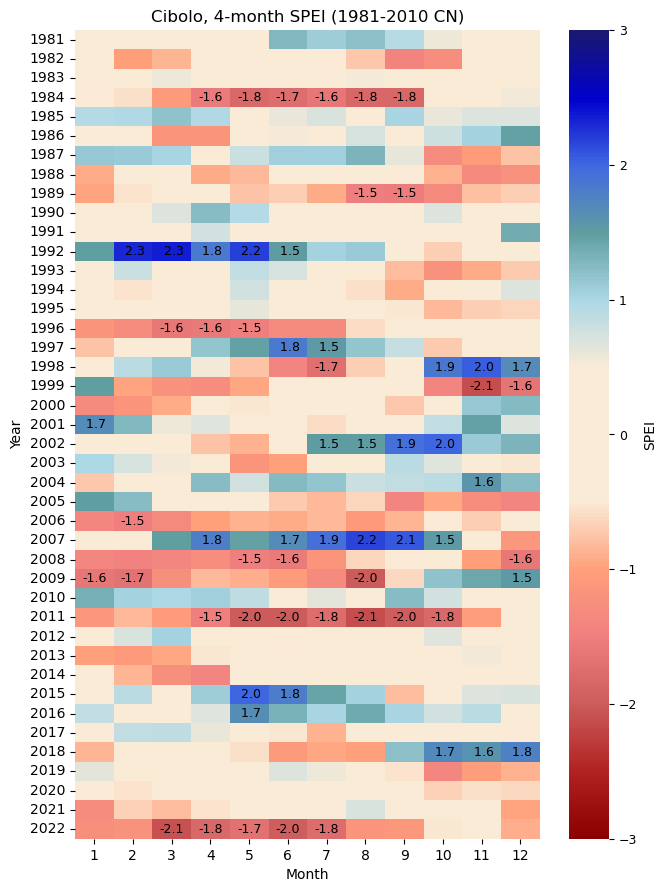

In [65]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.5, 10.5)
ax11 = Fig1.add_subplot(111)
ax11 = sns.heatmap( pvbT4Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPEI',}, ax=ax11 )
cbar = ax11.collections[0].colorbar
cbar.ax.tick_params(labelsize=9)
ax11.set_title( "%s, 4-month SPEI (1981-2010 CN)" % BasKey, fontsize=12 )
ax11.set_xlabel('Month', fontsize=10 )
ax11.set_ylabel('Year', fontsize=10)
ax11.tick_params(axis='both', which='major', labelsize=10)

Loop through headers and make individual plots for each subbasin and each rolling window

In [66]:
for tHdr in ["SPEI"]:
    svLabel = BasKey
    # now need to work on the 3 month plot
    bT3Mo = spei3DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT3Mo["Month"] = bT3Mo.index.month
    bT3Mo["Year"] = bT3Mo.index.year
    bT4Mo = spei4DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT4Mo["Month"] = bT4Mo.index.month
    bT4Mo["Year"] = bT4Mo.index.year
    bT6Mo = spei6DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT6Mo["Month"] = bT6Mo.index.month
    bT6Mo["Year"] = bT6Mo.index.year
    bT12Mo = spei12DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT12Mo["Month"] = bT12Mo.index.month
    bT12Mo["Year"] = bT12Mo.index.year
    # pivot
    pvbT3Mo = bT3Mo.pivot( index="Year", columns="Month", values=tHdr)
    pvbT4Mo = bT4Mo.pivot( index="Year", columns="Month", values=tHdr)
    pvbT6Mo = bT6Mo.pivot( index="Year", columns="Month", values=tHdr)
    pvbT12Mo = bT12Mo.pivot( index="Year", columns="Month", values=tHdr)
    # do our plots
    #   3 month
    #   annotation stuff
    # get the annotation stuff
    NumYrs = len( pvbT3Mo )
    allSPEI_1 = pvbT3Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_3mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_3mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_3mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT3Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPEI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 3-month SPEI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
    #   4 month
    #   annotation stuff
    # get the annotation stuff
    NumYrs = len( pvbT4Mo )
    allSPEI_1 = pvbT4Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_4mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_4mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_4mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT4Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPEI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 4-month SPEI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
    #   6 month
    # get the annotation stuff
    NumYrs = len( pvbT6Mo )
    allSPEI_1 = pvbT6Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_6mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_6mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_6mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT6Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPEI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Baasin, 6-month SPEI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600)
    Fig1.savefig( OutFilePNG, dpi=600)
    Fig1.savefig( OutFilePDF, dpi=600)
    # clear the figures
    plt.cla()
    plt.close(Fig1)
    #   12 month
    # get the annotation stuff
    NumYrs = len( pvbT12Mo )
    allSPEI_1 = pvbT12Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_12mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_12mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPEI_12mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT12Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPEI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 12-month SPEI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
# end for

#### SPI

In [67]:
for tHdr in ["SPI"]:
    svLabel = BasKey
    # now need to work on the 3 month plot
    bT3Mo = spi3DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT3Mo["Month"] = bT3Mo.index.month
    bT3Mo["Year"] = bT3Mo.index.year
    bT4Mo = spi4DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT4Mo["Month"] = bT4Mo.index.month
    bT4Mo["Year"] = bT4Mo.index.year
    bT6Mo = spi6DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT6Mo["Month"] = bT6Mo.index.month
    bT6Mo["Year"] = bT6Mo.index.year
    bT12Mo = spi12DF[[tHdr]].loc[pd.Timestamp(1993, 1, 1,):].copy()
    bT12Mo["Month"] = bT12Mo.index.month
    bT12Mo["Year"] = bT12Mo.index.year
    # pivot
    pvbT3Mo = bT3Mo.pivot( index="Year", columns="Month", values=tHdr)
    pvbT4Mo = bT4Mo.pivot( index="Year", columns="Month", values=tHdr)
    pvbT6Mo = bT6Mo.pivot( index="Year", columns="Month", values=tHdr)
    pvbT12Mo = bT12Mo.pivot( index="Year", columns="Month", values=tHdr)
    # do our plots
    #   3 month
    #   annotation stuff
    # get the annotation stuff
    NumYrs = len( pvbT3Mo )
    allSPEI_1 = pvbT3Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_3mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_3mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_3mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT3Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 3-month SPI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
    #   4 month
    #   annotation stuff
    # get the annotation stuff
    NumYrs = len( pvbT4Mo )
    allSPEI_1 = pvbT4Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_4mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_4mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_4mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT4Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 4-month SPI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
    #   6 month
    #   annotation stuff
    # get the annotation stuff
    NumYrs = len( pvbT6Mo )
    allSPEI_1 = pvbT6Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_6mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_6mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_6mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT6Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 6-month SPI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
    #   12 month
    #   annotation stuff
    # get the annotation stuff
    NumYrs = len( pvbT12Mo )
    allSPEI_1 = pvbT12Mo.to_numpy( dtype=np.float32 )
    matLister1 = list()
    for iI in range( NumYrs ):
        rowLister = list()
        for jJ in range(12):
            cVal = allSPEI_1[iI, jJ]
            if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
                rowLister.append( "%4.1f" % cVal )
            else:
                rowLister.append( "" )
            # end if
        # end inner for
        matLister1.append( rowLister )
    # end outer for
    AnnotMat_1 = np.array( matLister1 )
    OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_12mon.pdf" % svLabel))
    OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_12mon.svg" % svLabel))
    OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, BasKey, "Plots", "%s_SPI_12mon.png" % svLabel))
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.5, 10.5)
    ax11 = Fig1.add_subplot(111)
    ax11 = sns.heatmap( pvbT12Mo, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                        annot=AnnotMat_1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                        annot_kws={'fontsize':9, 'color':'xkcd:black'},
                        cbar_kws={'label': 'SPI',}, ax=ax11 )
    cbar = ax11.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    ax11.set_title( "%s Basin, 12-month SPI (1981-2010 CN)" % svLabel, fontsize=12 )
    ax11.set_xlabel('Month', fontsize=10 )
    ax11.set_ylabel('Year', fontsize=10)
    ax11.tick_params(axis='both', which='major', labelsize=10)
    Fig1.savefig( OutFileSVG, dpi=600 )
    Fig1.savefig( OutFilePNG, dpi=600 )
    Fig1.savefig( OutFilePDF, dpi=600 )
    # clear the figures
    plt.cla()
    plt.close(Fig1)
# end for